<H1> Classification de données textuelles </H1>


Lors de l'étape d'ingénierie de données textuelles nous avons vu que diverses opérations pouvaient être appliquées sur les textes et qu'au final il est possible d'obtenir des textes simplifiés. Nous allons, à présent, étudier comment faire de la classification à partir de données textuelles et comment convertir les textes en vecteurs pour pouvoir faire de la classification. 


## **Installation**




Avant de commencer, il est nécessaire de déjà posséder dans son environnement toutes les librairies utiles. Dans la seconde cellule nous importons toutes les librairies qui seront utiles à ce notebook. Il se peut que, lorsque vous lanciez l'éxecution de cette cellule, une soit absente. Dans ce cas il est nécessaire de l'installer. Pour cela dans la cellule suivante utiliser la commande :  

*! pip install nom_librairie*  

**Attention :** il est fortement conseillé lorsque l'une des librairies doit être installer de relancer le kernel de votre notebook.

**Remarque :** même si toutes les librairies sont importées dès le début, les librairies utilisées lors de la présentation d'une fonction dans une cellule sont ré-importées de manière à indiquer d'où elles viennent et ainsi connaîter d'où vient la fonction afin de vous faciliter la réutilisation dans un autre projet.
 

In [40]:
# utiliser cette cellule pour installer les librairies manquantes
# pour cela il suffit de taper dans cette cellule : !pip install nom_librairie_manquante
# d'exécuter la cellule et de relancer la cellule suivante pour voir si tout se passe bien
# recommencer tant que toutes les librairies ne sont pas installées ...


#!pip install ..

# ne pas oublier de relancer le kernel du notebook

In [41]:
# Importation des différentes librairies, classes et fonctions utilespour le notebook

#Sickit learn met régulièrement à jour des versions et 
#indique des futurs warnings. 
#ces deux lignes permettent de ne pas les afficher.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# librairies générales
import pandas as pd
import re
from tabulate import tabulate
import time
import numpy as np
import pickle
import string
import base64
import sys

# librairie affichage
import matplotlib.pyplot as plt
import seaborn as sns

# librairies scikit learn
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


# librairies des classifiers utilisés
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# librairies NLTK
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer 
from nltk.corpus import stopwords
from nltk import word_tokenize 

 
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english')) 

    

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Pour pouvoir sauvegarder sur votre répertoire Google Drive, il est nécessaire de fournir une autorisation. Pour cela il suffit d'éxecuter la ligne suivante et de saisir le code donné par Google.

In [42]:
# pour monter son drive Google Drive local
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Corriger éventuellement la ligne ci-dessous pour mettre le chemin vers un répertoire spécifique dans votre répertoire Google Drive : 

In [43]:
my_local_drive='/content/gdrive/My Drive/Colab Notebooks/ML_FDS'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd

/content/gdrive/My Drive/Colab Notebooks/ML_FDS


'/content/gdrive/My Drive/Colab Notebooks/ML_FDS'

In [44]:
# fonctions utilities (affichage, confusion, etc.)
from MyNLPUtilities import *

## **Vectorisation**



L'objectif de la vectorisation est de transformer les documents en vecteurs. Il existe deux approches principales : 
1. L'approche sac de mots dans laquelle il n'y a aucun ordre dans les termes utilisés et qui ne tient compte que du nombre d'occurrences des termes
1. l'approche basée sur TF_IDF qui ne tient pas non plus compte de l'ordre des termes mais qui pondère les valeurs grâce à TF_IDF au lieu de la fréquence des termes.

**Remarque :** même si l'ordre des mots n'est pas pris en compte dans ces approches, les n-grammes peuvent partiellement servir à pallier ce problème. 

### **L'approche Sac de Mots (*Bag of Words*)**




La manière la plus simple de mettre sous la forme de vecteur (*vectorisation*) est d'utiliser les Bag of Words (BOW). Il s'agit, à partir d'une liste de mots (vocabulaire) de compter le nombre d'apparitions du mot du vocabulaire dans le document.  

Cette opération se fait par :
1. Création d'une instance de la classe CountVectorizer.
1. Appel de la fonction fit() pour apprendre le vocabulaire.
1. Appel de la fonction transform() sur un ou plusieurs documents afin de les encoder dans le vecteur.  

La classe CountVectorizer permet également de faire un ensemble de pré-traitement sur un document : mise en minuscule, suppression des stop words (mots vides), suppression des ponctuations ... mais elle ne peut pas lemmatiser ou rechercher les racines des termes. 

Les principaux paramètres utiles sont les suivants :  
1. *lowercase* booléen pour mettre en minuscule le document (défaut=True).
1. *token_pattern* pour éliminer des mots trop petits (défaut=None).
1. *stopwords* pour éliminer les stopwords du document (défaut=None).
1. *analyzer* pour préciser si l'on travaille avec des mots ou des caractères ou appliquer une fonction de pré-traitement (défaut=’word’).
1. *ngram_range* pour pouvoir utiliser des n-grammes de mots ou de caractères en fonction de la valeur d'*analyzer* (défaut=(1, 1), i.e. on ne considère qu'un mot).
1. *max_df* pour ignorer les termes qui ont une fréquence de document strictement supérieure à un seuil donné (termes trop fréquents) (défaut=1.0).
1. *min_df* pour ignorer les termes qui ont une fréquence de document (présence en % de documents) strictement inférieure à un seuil donné (termes peu fréquents) (défaut=1).
1. *max_features* pour limiter le nombre de caractéristiques (*features*) que le vecteur doit contenir (défaut : None).


Pour avoir plus d'information sur CountVectorizer, voir https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html  

Nous décrivons par la suite les différents paramètres.

In [45]:
from sklearn.feature_extraction.text import CountVectorizer
#premier exemple sans paramètre
texte = ["This is a simple EXAMPLE ! of CountVectorizer for creating a vector"]

print ("document initial ",texte,'\n')
# par defaut conversion en minuscule
vectorizer = CountVectorizer()

# creation du vocabulaire
vectorizer.fit(texte)
# encodage du document
vector = vectorizer.transform(texte)

# la liste des différents features
print ("Les différents features sont",vectorizer.get_feature_names(),' ... à noter tout est converti en minuscule\n')

# Contenu du vocabulaire
print ("Vocabulaire : ")
print(vectorizer.vocabulary_)


# affichage de la taille du vecteur de sortie

print ("\nTaille du vecteur :\n",vector.shape,'\n')

print ("Conversion en mettant lowercase=False")
vectorizer = CountVectorizer(lowercase=False)
# creation du vocabulaire
vectorizer.fit(texte)

# la liste des différents features
print ("Les différents features sont",vectorizer.get_feature_names(),' ... à noter les majuscules sont conservées\n')

document initial  ['This is a simple EXAMPLE ! of CountVectorizer for creating a vector'] 

Les différents features sont ['countvectorizer', 'creating', 'example', 'for', 'is', 'of', 'simple', 'this', 'vector']  ... à noter tout est converti en minuscule

Vocabulaire : 
{'this': 7, 'is': 4, 'simple': 6, 'example': 2, 'of': 5, 'countvectorizer': 0, 'for': 3, 'creating': 1, 'vector': 8}

Taille du vecteur :
 (1, 9) 

Conversion en mettant lowercase=False
Les différents features sont ['CountVectorizer', 'EXAMPLE', 'This', 'creating', 'for', 'is', 'of', 'simple', 'vector']  ... à noter les majuscules sont conservées



Il est possible de combiner *fit* et *transform* comme le montre l'exemple suivant où nous créons également un dataframe pour afficher le vecteur résultat.

In [46]:
from sklearn.feature_extraction.text import CountVectorizer

texte = ["This is an example, ! of CountVectorizer for creating a vector",
        "This is another example of CountVectorizer",
        "with or without parameters"]

vectorizer = CountVectorizer()
# fit et transform en une opération
X = vectorizer.fit_transform(texte)

# creation du dataframe pour affichage
df = pd.DataFrame(
    data=vectorizer.transform(texte).toarray(),
    columns=vectorizer.get_feature_names()
)

display(df)

,an,another,countvectorizer,creating,example,for,is,of,or,parameters,this,vector,with,without
0,1,0,1,1,1,1,1,1,0,0,1,1,0,0
1,0,1,1,0,1,0,1,1,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,1,1,0,0,1,1


**token_pattern**  

*token_pattern* peut être utilisé pour filtrer uniquement les mots qui font une certaine taille. Elle est, par exemple, fort utile pour supprimer les termes composés d'un seul caractère. Pour cela, il faut préciser une expression régulière.

In [47]:
texte = ["This is an example, ! of CountVectorizer for creating a vector",
        "This is another example of CountVectorizer",
        "with or without parameters"]

print ("Le vocabulaire ne contient que des mots qui ont plus de trois caractères :")
vectorizer = CountVectorizer(token_pattern=r'\w{3,}')  

# fit et transform en une opération
X = vectorizer.fit_transform(texte)

# creation du dataframe pour affichage
df = pd.DataFrame(
    data=vectorizer.transform(texte).toarray(),
    columns=vectorizer.get_feature_names()
)

display(df)

Le vocabulaire ne contient que des mots qui ont plus de trois caractères :


,another,countvectorizer,creating,example,for,parameters,this,vector,with,without
0,0,1,1,1,1,0,1,1,0,0
1,1,1,0,1,0,0,1,0,0,0
2,0,0,0,0,0,1,0,0,1,1


**stop_words**  

*stop_words* permet de supprimer du vocabulaire les mots qui appartiennent aux stopwords d'une langue (e.g. stopwords='english'). Il se base sur une liste de stopwords définie. Il est également possible de préciser sa propre liste de stopwords. 


In [48]:
texte = ["This is an example, ! of CountVectorizer for creating a vector",
        "This is another example of CountVectorizer",
        "with or without parameters"]

print ("Le vocabulaire ne contient que des mots qui ne sont pas des stopwords anglais :")
vectorizer = CountVectorizer(stop_words='english')  

# fit et transform en une opération
X = vectorizer.fit_transform(texte)

# creation du dataframe pour affichage
df = pd.DataFrame(
    data=vectorizer.transform(texte).toarray(),
    columns=vectorizer.get_feature_names()
)

display(df)

print ("Le vocabulaire ne contient que des mots qui ne sont pas dans une liste spécifiée de stopwords (example, vector, creating) : ")
vectorizer = CountVectorizer(stop_words=['example','vector','creating'])  

# fit et transform en une opération
X = vectorizer.fit_transform(texte)

# creation du dataframe pour affichage
df = pd.DataFrame(
    data=vectorizer.transform(texte).toarray(),
    columns=vectorizer.get_feature_names()
)

display(df)

Le vocabulaire ne contient que des mots qui ne sont pas des stopwords anglais :


,countvectorizer,creating,example,parameters,vector
0,1,1,1,0,1
1,1,0,1,0,0
2,0,0,0,1,0


Le vocabulaire ne contient que des mots qui ne sont pas dans une liste spécifiée de stopwords (example, vector, creating) : 


,an,another,countvectorizer,for,is,of,or,parameters,this,with,without
0,1,0,1,1,1,1,0,0,1,0,0
1,0,1,1,0,1,1,0,0,1,0,0
2,0,0,0,0,0,0,1,1,0,1,1


**Les n-grammes**  
Il est possible de préciser que les features sont composés de n-grammes à l'aide du paramètre *ngram_range*. Ce dernier spécifie l'intervalle de valeurs possibles. Par exemple *ngram_range=(1, 2)* permettra d'obtenir des n-grammes de taille 1 et 2 mots, *ngram_range=(1, 3)* des n-grammes de 1, 2 et 3 mots, *ngram_range=(3, 3)* des n-grammes de 3 mots, etc.  

Par défaut, il s'agit de n-grammes de mots, pour avoir des n-grammes de caractères, le paramètre *analyzer* doit être initialisé avec *analyzer='char'*. 

In [49]:
texte = ["This is an example of CountVectorizer for creating a vector",
        "This is another example of CountVectorizer",
        "with or without parameters"]

print ("n-grammes de mots de taille 1")
vectorizer = CountVectorizer(ngram_range=(1,1))
# fit et transform en une opération
X = vectorizer.fit_transform(texte)
print (vectorizer.get_feature_names())

print ("\nn-grammes de mots de taille 1 et 2")
vectorizer = CountVectorizer(ngram_range=(1,2))
# fit et transform en une opération
X = vectorizer.fit_transform(texte)
print (vectorizer.get_feature_names())

print ("\nn-grammes de mots de taille 2 et 3")
vectorizer = CountVectorizer(ngram_range=(2,3))
# fit et transform en une opération
X = vectorizer.fit_transform(texte)
print (vectorizer.get_feature_names())

print ("\nn-grammes de mots de taille 3")
vectorizer = CountVectorizer(ngram_range=(3,3))
# fit et transform en une opération
X = vectorizer.fit_transform(texte)
print (vectorizer.get_feature_names())


print ("\nn-grammes de caractères de taille 1 et 2")
vectorizer = CountVectorizer(analyzer='char',ngram_range=(1,2))
# fit et transform en une opération
X = vectorizer.fit_transform(texte)
print (vectorizer.get_feature_names())

n-grammes de mots de taille 1
['an', 'another', 'countvectorizer', 'creating', 'example', 'for', 'is', 'of', 'or', 'parameters', 'this', 'vector', 'with', 'without']

n-grammes de mots de taille 1 et 2
['an', 'an example', 'another', 'another example', 'countvectorizer', 'countvectorizer for', 'creating', 'creating vector', 'example', 'example of', 'for', 'for creating', 'is', 'is an', 'is another', 'of', 'of countvectorizer', 'or', 'or without', 'parameters', 'this', 'this is', 'vector', 'with', 'with or', 'without', 'without parameters']

n-grammes de mots de taille 2 et 3
['an example', 'an example of', 'another example', 'another example of', 'countvectorizer for', 'countvectorizer for creating', 'creating vector', 'example of', 'example of countvectorizer', 'for creating', 'for creating vector', 'is an', 'is an example', 'is another', 'is another example', 'of countvectorizer', 'of countvectorizer for', 'or without', 'or without parameters', 'this is', 'this is an', 'this is anoth

**min_df et max_df**  

*min_df* ignore les termes qui ont une fréquence de document (présence en % de documents) strictement inférieure au seuil donné. Par exemple, *min_df = 0,55* exige qu'un terme apparaisse dans 55% des documents pour être considéré comme faisant partie du vocabulaire. *max_df* à l'inverse ignore les termes qui sont supérieurs au seuil. Il est utilisé, par exemple, pour éliminer les termes trop fréquents.

In [50]:
texte = ["This is an example of CountVectorizer for creating a vector",
        "This is another example of CountVectorizer",
        "with or without parameters"]


print ("Ne conserver que les termes qui apparaissent dans au moins 50% des documents avec min_df=0.5")
vectorizer = CountVectorizer(min_df=0.5)
# fit et transform en une opération
X = vectorizer.fit_transform(texte)
print (vectorizer.get_feature_names())

print ("Ne conserver que les termes qui sont inférieurs à 50% des documents avec max_df=0.5")
vectorizer = CountVectorizer(max_df=0.5)
# fit et transform en une opération
X = vectorizer.fit_transform(texte)
print (vectorizer.get_feature_names())

Ne conserver que les termes qui apparaissent dans au moins 50% des documents avec min_df=0.5
['countvectorizer', 'example', 'is', 'of', 'this']
Ne conserver que les termes qui sont inférieurs à 50% des documents avec max_df=0.5
['an', 'another', 'creating', 'for', 'or', 'parameters', 'vector', 'with', 'without']


**max_features**  
*max_features* permet de préciser la taille de sortie du vecteur, i.e. le nombre de termes à conserver.

In [51]:
texte = ["This is an example of CountVectorizer for creating a vector",
        "This is another example of CountVectorizer",
       "with or without parameters"]

print ("Ne conserver que 8 features pour le vocabulaire")
vectorizer = CountVectorizer(max_features=8)
# fit et transform en une opération
X = vectorizer.fit_transform(texte)
print (vectorizer.get_feature_names())

print ("Pas de contraintes sur la taille du vocabulaire")
vectorizer = CountVectorizer()
# fit et transform en une opération
X = vectorizer.fit_transform(texte)
print (vectorizer.get_feature_names())

Ne conserver que 8 features pour le vocabulaire
['an', 'another', 'countvectorizer', 'creating', 'example', 'is', 'of', 'this']
Pas de contraintes sur la taille du vocabulaire
['an', 'another', 'countvectorizer', 'creating', 'example', 'for', 'is', 'of', 'or', 'parameters', 'this', 'vector', 'with', 'without']


**Remarque :** l'inconvénient de CountVectorizer est qu'il génère des matrices qui sont creuses, i.e. il y a beaucoup de zéros. L'exemple suivant illustre le contenu de la matrice précédente où le bleu foncé indique qu'il y a une valeur et le bleu claire indique un zéro.

Text(0.5, 1.0, 'Matrice Creuse pour CountVectorizer')

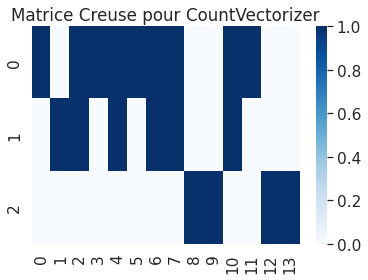

In [52]:
sns.heatmap(X.todense(), cmap="Blues", vmin=0, vmax=1).set_title('Matrice Creuse pour CountVectorizer')

### **L'approche via TF_IDF** 



Le but de l'utilisation de tf-idf est de réduire l'impact des termes qui apparaissent très fréquemment dans un corpus donné et qui sont donc moins informatifs que les autres termes dans le corpus d'apprentissage. 

CountVectorizer, en prenant en compte l'occurrence des mots, est souvent trop limité. Une alternative est d'utiliser la 
mesure TF-IDF (Term Frequency – Inverse Document) qui a pour but de réduire l'impact des termes qui apparaissent très fréquemment dans un corpus donné :  

$
 tf$-$idf(d, t) = tf(t) * idf(d, t)
$  

où $tf(t)$= la fréquence du terme, i.e. le nombre de fois où le terme apparaît dans le document  
et $idf(d, t)$ = la fréquence du document, i.e. le nombre de documents 'd' qui contiennent le terme 't'. 

Le principe est le même que pour CountVectorizer, cette opération se fait par :
1. Création d'une instance de la classe TfidfVectorizer.
1. Appel de la fonction fit() pour apprendre le vocabulaire.
1. Appel de la fonction transform() sur un ou plusieurs documents afin de les encoder dans le vecteur.  

Les paramètres sont assez similaires à ceux de CountVectorizer, voir https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html


**Remarque :** Il est possible, si CountVectorizer a déjà été utilisé, de le faire suivre par TfidfTransformer pour simplement mettre à jour les valeurs.

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer

texte = ["This is an example of TfidfVectorizer for creating a vector",
        "This is another example of TfidfVectorizer",
        "with or without parameters"]

print ("Application de TfidfVectorizer :")
vectorizer = TfidfVectorizer()
# fit et transform en une opération
X = vectorizer.fit_transform(texte)

# creation du dataframe pour affichage
df = pd.DataFrame(
    data=vectorizer.transform(texte).toarray(),
    columns=vectorizer.get_feature_names()
)

display(df)

Application de TfidfVectorizer :


,an,another,creating,example,for,is,of,or,parameters,tfidfvectorizer,this,vector,with,without
0,0.380914,0.00000,0.380914,0.289695,0.380914,0.289695,0.289695,0.0,0.0,0.289695,0.289695,0.380914,0.0,0.0
1,0.000000,0.50689,0.000000,0.385503,0.000000,0.385503,0.385503,0.0,0.0,0.385503,0.385503,0.000000,0.0,0.0
2,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.5,0.5,0.000000,0.000000,0.000000,0.5,0.5


Il est possible d'obtenir l'idf de chaque terme du vocabulaire via l'attribut *idf_* :

In [54]:
print ("Affichage de l'idf de chaque terme du vocabulaire : ");

print(dict(zip(vectorizer.get_feature_names(), vectorizer.idf_)))

Affichage de l'idf de chaque terme du vocabulaire : 
{'an': 1.6931471805599454, 'another': 1.6931471805599454, 'creating': 1.6931471805599454, 'example': 1.2876820724517808, 'for': 1.6931471805599454, 'is': 1.2876820724517808, 'of': 1.2876820724517808, 'or': 1.6931471805599454, 'parameters': 1.6931471805599454, 'tfidfvectorizer': 1.2876820724517808, 'this': 1.2876820724517808, 'vector': 1.6931471805599454, 'with': 1.6931471805599454, 'without': 1.6931471805599454}


Un exemple combinant différents attributs :

In [55]:
texte = ["This is an example of TfidfVectorizer for creating a vector",
        "This is another example of TfidfVectorizer",
        "with or without parameters"]

print ("Application de TfidfVectorizer avec ngram_range=(1,2) et suppression des stopwords :")
vectorizer = TfidfVectorizer(stop_words='english',ngram_range=(1,2))
# fit et transform en une opération
X = vectorizer.fit_transform(texte)

# creation du dataframe pour affichage
df = pd.DataFrame(
    data=vectorizer.transform(texte).toarray(),
    columns=vectorizer.get_feature_names()
)

display(df)

Application de TfidfVectorizer avec ngram_range=(1,2) et suppression des stopwords :


,creating,creating vector,example,example tfidfvectorizer,parameters,tfidfvectorizer,tfidfvectorizer creating,vector
0,0.417567,0.417567,0.31757,0.31757,0.0,0.31757,0.417567,0.417567
1,0.000000,0.000000,0.57735,0.57735,0.0,0.57735,0.000000,0.000000
2,0.000000,0.000000,0.00000,0.00000,1.0,0.00000,0.000000,0.000000


**Remarque :** l'un des gros avantages de TfidfVectorizer par rapport à CountVectorizer est qu'il génère des matrices moins creuses.

<font color=red>Exercice :</font> CountVectorizer et TfidfVectorizer ne possèdent pas de dictionnaire de stop words français. Cependant nous avons vu qu'il était possible de passer comme paramètre une liste de stopwords à supprimer.  
Télécharger le fichier : StopWordsFrench.csv et sauvegarder le sur votre répertoire courant.  

Pour cela vous pouvez utiliser directement la commande :  




In [56]:
!wget https://www.lirmm.fr/~poncelet/Ressources/StopWordsFrench.csv  

--2022-01-12 16:22:13--  https://www.lirmm.fr/~poncelet/Ressources/StopWordsFrench.csv
Resolving www.lirmm.fr (www.lirmm.fr)... 193.49.104.251
Connecting to www.lirmm.fr (www.lirmm.fr)|193.49.104.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1925 (1.9K) [text/csv]
Saving to: ‘StopWordsFrench.csv.2’

StopWordsFrench.csv 100%[===================>]   1.88K  --.-KB/s    in 0s      

2022-01-12 16:22:14 (37.4 MB/s) - ‘StopWordsFrench.csv.2’ saved [1925/1925]



Cette liste a été obtenue à partir du site : https://referencement-gratuit.and-co.ch/download/liste-stop-words-francais.txt

Compléter la cellule suivante de manière à créer un pipeline qui élimine les stopwords français et détermine des n-grammes d'intervalle 1 à 2, que les features ne soient pas convertis en minuscule et qu'au final le nombre de features soit égal à 15. Il faut tester à la fois pour CountVectorizer et TfidfVectorizer. 

In [57]:
list_french_stopwords=pd.read_csv("StopWordsFrench.csv", sep=',',index_col = 0)
# conversion en liste
list_french_stopwords=list_french_stopwords.values.tolist()


texte = ["Au clair de la lune",
         "mon ami Pierrot",
        "Prête-moi ta plume",
        "Pour écrire un mot",
        "Ma chandelle est morte"
        "Je n'ai plus de feu"]

<font color=blue>Solution :</font>

,Au,de,feu,la,la lune,lune,moi,moi ta,mon,mon ami,morteJe,mot,plume,plus,plus de
0,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
2,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,1,1,0,0,0,0,0,0,0,1,0,0,1,1


,Au,de,feu,la,la lune,lune,moi,moi ta,mon,mon ami,morteJe,mot,plume,plus,plus de
0,0.463693,0.374105,0.000000,0.463693,0.463693,0.463693,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.707107,0.707107,0.000000,0.0,0.00000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.57735,0.57735,0.000000,0.000000,0.000000,0.0,0.57735,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,1.0,0.00000,0.000000,0.000000
4,0.000000,0.374105,0.463693,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.463693,0.0,0.00000,0.463693,0.463693


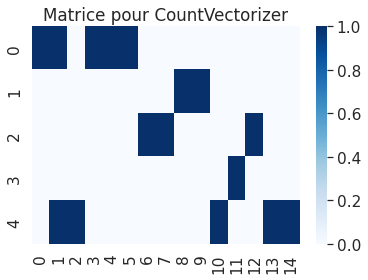

In [58]:
# Pour CountVectorizer
vectorizer = CountVectorizer(lowercase=False,stop_words=list_french_stopwords,ngram_range=(1,2),max_features=15)
# fit et transform en une operation
X = vectorizer.fit_transform(texte)

# creation du dataframe pour affichage
df = pd.DataFrame(
    data=vectorizer.transform(texte).toarray(),
    columns=vectorizer.get_feature_names()
)

display(df)
sns.heatmap(X.todense(), cmap='Blues', vmin=0, vmax=1).set_title('Matrice pour CountVectorizer')

# Pour TF-IDF
vectorizer = TfidfVectorizer(lowercase=False,stop_words=list_french_stopwords,ngram_range=(1,2),max_features=15)
X = vectorizer.fit_transform(texte)


df = pd.DataFrame(
    data=vectorizer.transform(texte).toarray(),
    columns=vectorizer.get_feature_names()
)

display(df)

## **Prise en compte des prétraitements avant transformation**  



Précédemment nous avons vu qu'il était possible d'appliquer de très nombreux pré-traitements sur les documents. Même si CountVectorizer et TfidfVectorizer offrent certaines fonctionnalités, ces dernières ne sont pas forcément suffisantes. Dans cette section, nous présentons comment les pipelines peuvent être utilisés pour mettre en place une chaîne de traitement qui pré-traite les données pour les convertir en vecteurs.  

Considérons la fonction suivante qui effectue un certain nombre de pré-traitements sur un seul document. Par défaut, les paramètres sont à False pour effectuer les pré-traitements. Pour l'activer un pré-traitement, il suffit de mettre le paramètre à True. 


In [59]:
import re
import string

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer 
from nltk.corpus import stopwords
from nltk import word_tokenize

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english')) 

def MyCleanText(X, 
               lowercase=False, # mettre en minuscule
               removestopwords=False, # supprimer les stopwords
               removedigit=False, # supprimer les nombres  
               getstemmer=False, # conserver la racine des termes
               getlemmatisation=False # lematisation des termes 
              ):
    
    sentence=str(X)

    # suppression des caractères spéciaux
    sentence = re.sub(r'[^\w\s]',' ', sentence)
    # suppression de tous les caractères uniques
    sentence = re.sub(r'\s+[a-zA-Z]\s+', ' ', sentence)
    # substitution des espaces multiples par un seul espace
    sentence = re.sub(r'\s+', ' ', sentence, flags=re.I)

    # decoupage en mots
    tokens = word_tokenize(sentence)
    if lowercase:
          tokens = [token.lower() for token in tokens]

    # suppression ponctuation
    table = str.maketrans('', '', string.punctuation)
    words = [token.translate(table) for token in tokens]

    # suppression des tokens non alphabetique ou numerique
    words = [word for word in words if word.isalnum()]
    
    # suppression des tokens numerique
    if removedigit:
        words = [word for word in words if not word.isdigit()]

    # suppression des stopwords
    if removestopwords:
        words = [word for word in words if not word in stop_words]

    # lemmatisation
    if getlemmatisation:
        lemmatizer=WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word)for word in words]
        

    # racinisation
    if getstemmer:
        ps = PorterStemmer()
        words=[ps.stem(word) for word in words]
        
    sentence= ' '.join(words)
  
    return sentence   

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


L'exemple suivant illustre 3 cas d'utilisation : 

In [60]:
texte = """This is an example of using the Function MyCleanText before creating a vector created, \
          this text has some problems like 1 c or even numbers like 13 and we have corpora"""

print ("Texte d'origine :\n", texte,'\n')
print ('Utilisation de MyCleanText avec les paramètres par défaut (nettoyage des caractères spéciaux, des caractères uniques etc)')
print (MyCleanText(texte),'\n')

print ('Utilisation de MyCleanText avec convertion en minuscule, en prenant les racines, en supprimant les nombres')
print (MyCleanText(texte,lowercase=True,getstemmer=True, removedigit=True),'\n')

print ('Utilisation de MyCleanText avec convertion en minuscule et en mettant sous la forme de lemmes')
print (MyCleanText(texte,lowercase=True,getlemmatisation=True),'\n')

Texte d'origine :
 This is an example of using the Function MyCleanText before creating a vector created,           this text has some problems like 1 c or even numbers like 13 and we have corpora 

Utilisation de MyCleanText avec les paramètres par défaut (nettoyage des caractères spéciaux, des caractères uniques etc)
This is an example of using the Function MyCleanText before creating vector created this text has some problems like 1 or even numbers like 13 and we have corpora 

Utilisation de MyCleanText avec convertion en minuscule, en prenant les racines, en supprimant les nombres
thi is an exampl of use the function mycleantext befor creat vector creat thi text ha some problem like or even number like and we have corpora 

Utilisation de MyCleanText avec convertion en minuscule et en mettant sous la forme de lemmes
this is an example of using the function mycleantext before creating vector created this text ha some problem like 1 or even number like 13 and we have corpus 



**Les estimateurs et Transformer**  

Scikit learn propose une interface Transformer qui est un type spécial d'estimateur qui crée un nouvel ensemble de données à partir d'un ancien en fonction de règles apprises lors de l'appel à la fonction *fit*. Il existe de très nombreux Transformer dans Scikit-Learn pour normaliser, mettre à l'échelle, gérer les valeurs manquantes, réduire les dimensions, etc. 
De nombreuses informations sur les estimateurs proposés et leurs utilisations sont disponibles ici : https://scikit-learn.org/stable/developers/develop.html  

L'interface de base pour un Transformer est la suivante : 

from sklearn.base import TransformerMixin

class Transfomer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        """
        Apprendre comme transformer les données en fonction des données d'entrées X.
        """
        return self

    def transform(self, X):
        """
        Transformer X dans un nouveau jeu de données Xprime et le retourner.
        """
        return Xprime

où via la méthode Transformer.transform nous pouvons transformer les données initiales.    

Nous pouvons par exemple construire la classe *TextNormalizer* qui effectue les pré-traitements sur les données (suppression stopwords, récupération des racines, etc.) définis dans la fonction MyCleanText 

In [61]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextNormalizer(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 removestopwords=False, # suppression des stopwords
                 lowercase=False,# passage en minuscule
                 removedigit=False, # supprimer les nombres  
                 getstemmer=False,# racinisation des termes 
                 getlemmatisation=False # lemmatisation des termes  
                ):
        
        self.lowercase=lowercase
        self.getstemmer=getstemmer
        self.removestopwords=removestopwords
        self.getlemmatisation=getlemmatisation
        self.removedigit=removedigit

    def transform(self, X, **transform_params):
        # Nettoyage du texte
        X=X.copy() # pour conserver le fichier d'origine
        return [MyCleanText(text,lowercase=self.lowercase,
                            getstemmer=self.getstemmer,
                            removestopwords=self.removestopwords,
                            getlemmatisation=self.getlemmatisation,
                            removedigit=self.removedigit) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self
    
    def fit_transform(self, X, y=None, **fit_params):
        return self.fit(X).transform(X)

    def get_params(self, deep=True):
        return {
            'lowercase':self.lowercase,
            'getstemmer':self.getstemmer,
            'removestopwords':self.removestopwords,
            'getlemmatisation':self.getlemmatisation,
            'removedigit':self.removedigit
        }    
    
    def set_params (self, **parameters):
        for parameter, value in parameters.items():
            setattr(self,parameter,value)
        return self    


Il est donc maintenant possible d'enchaîner des pré-traitement et l'application d'un tf-idf.

In [62]:
texte = ["This is an example of TfidfVectorizer for creating a vector",
        "This is another example of TfidfVectorizer",
        "but before we apply a preprocessing"]

print ("texte avant ",texte)
# il suffit de créer un objet de la classe TextNormalizer
text_normalizer=TextNormalizer(lowercase=True)  
# d'appliquer fit.transform pour appliquer les pré-traitements
text_cleaned=text_normalizer.fit_transform(texte)
print ("texte après application des pré-traitements")
print (text_cleaned)     

# pour l'enchainer avec un tf-idf : 
tfidf=TfidfVectorizer(ngram_range=(2, 2))
vector_tfidf=tfidf.fit_transform(text_cleaned)
print ("texte transformé en vecteur tf-idf")
print (vector_tfidf)

# le vecteur peut par la suite être transformé en matrice : 
print ("transformation du vecteur en matrice")
vector_tfidf.toarray()

# notons que cette matrice pourra être à l'entrée d'un classifier

texte avant  ['This is an example of TfidfVectorizer for creating a vector', 'This is another example of TfidfVectorizer', 'but before we apply a preprocessing']
texte après application des pré-traitements
['this is an example of tfidfvectorizer for creating vector', 'this is another example of tfidfvectorizer', 'but before we apply preprocessing']
texte transformé en vecteur tf-idf
  (0, 5)	0.38532288602703124
  (0, 7)	0.38532288602703124
  (0, 11)	0.38532288602703124
  (0, 10)	0.2930479866955796
  (0, 6)	0.2930479866955796
  (0, 0)	0.38532288602703124
  (0, 8)	0.38532288602703124
  (0, 12)	0.2930479866955796
  (1, 1)	0.5174199439321682
  (1, 9)	0.5174199439321682
  (1, 10)	0.39351120409397233
  (1, 6)	0.39351120409397233
  (1, 12)	0.39351120409397233
  (2, 2)	0.5
  (2, 13)	0.5
  (2, 3)	0.5
  (2, 4)	0.5
transformation du vecteur en matrice


array([[0.38532289, 0.        , 0.        , 0.        , 0.        ,
        0.38532289, 0.29304799, 0.38532289, 0.38532289, 0.        ,
        0.29304799, 0.38532289, 0.29304799, 0.        ],
       [0.        , 0.51741994, 0.        , 0.        , 0.        ,
        0.        , 0.3935112 , 0.        , 0.        , 0.51741994,
        0.3935112 , 0.        , 0.3935112 , 0.        ],
       [0.        , 0.        , 0.5       , 0.5       , 0.5       ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.5       ]])

La généralisation du principe précédent via un pipeline se fait alors simplement : 

In [63]:
from sklearn.pipeline import Pipeline

texte = ["This is an example of TextNormalizer then TfidfVectorizer for creating a vector",
        "This is not another example of CountVectorizer",
        "with or without parameters. Rather is a mainly a pipeline with more or less default parameters"]

pipe = Pipeline([("cleaner", TextNormalizer()),
                 ("count_vectorizer", TfidfVectorizer(ngram_range=(2, 2)))])
pipe.fit(texte)
pipe.transform(texte)


# creation du dataframe pour affichage
# il est possible d'accèder à une étape du pipeline en spécifiant le nom (e.g. pipe['cleaner'])
# dans le dataframe on récupère les différents features comme nom de colonnes
df = pd.DataFrame(
    data=pipe.transform(texte).toarray(),
    columns=pipe['count_vectorizer'].get_feature_names()
)

display(df)

,an example,another example,creating vector,default parameters,example of,for creating,is an,is mainly,is not,less default,mainly pipeline,more or,not another,of countvectorizer,of textnormalizer,or less,or without,parameters rather,pipeline with,rather is,textnormalizer then,tfidfvectorizer for,then tfidfvectorizer,this is,with more,with or,without parameters
0,0.330467,0.000000,0.330467,0.00000,0.251329,0.330467,0.330467,0.00000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.330467,0.00000,0.00000,0.00000,0.00000,0.00000,0.330467,0.330467,0.330467,0.251329,0.00000,0.00000,0.00000
1,0.000000,0.440362,0.000000,0.00000,0.334907,0.000000,0.000000,0.00000,0.440362,0.00000,0.00000,0.00000,0.440362,0.440362,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.334907,0.00000,0.00000,0.00000
2,0.000000,0.000000,0.000000,0.27735,0.000000,0.000000,0.000000,0.27735,0.000000,0.27735,0.27735,0.27735,0.000000,0.000000,0.000000,0.27735,0.27735,0.27735,0.27735,0.27735,0.000000,0.000000,0.000000,0.000000,0.27735,0.27735,0.27735


**Attention :** pour rappel CountVectorizer ou TfidfVectorizer mettent en minuscule par défaut. 


In [64]:
texte = ["This is an example of CountVectorizer for creating a vector",
        "This is another example of CountVectorizer",
        "with or without parameters"]

pipe = Pipeline([("cleaner", TextNormalizer(removestopwords=False,lowercase=False)),
                 ("count_vectorizer", TfidfVectorizer(lowercase=False))])
pipe.fit(texte)
pipe.transform(texte)


df = pd.DataFrame(
    data=pipe.transform(texte).toarray(),
    columns=pipe['count_vectorizer'].get_feature_names()
)

display(df)

,CountVectorizer,This,an,another,creating,example,for,is,of,or,parameters,vector,with,without
0,0.289695,0.289695,0.380914,0.00000,0.380914,0.289695,0.380914,0.289695,0.289695,0.0,0.0,0.380914,0.0,0.0
1,0.385503,0.385503,0.000000,0.50689,0.000000,0.385503,0.000000,0.385503,0.385503,0.0,0.0,0.000000,0.0,0.0
2,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.5,0.5,0.000000,0.5,0.5


## **Exemple de classification**

Maintenant que nous savons pré-traiter les données et construire des vecteurs nous pouvons passer à l'étape de classification. 
Le jeu de donnée que nous allons utiliser est tiré de la base de l'UCI : https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences
et a été créée par : "From Group to Individual Labels using Deep Features', Kotzias et. al,. KDD 2015".  

Il contient des phrases d'avis de trois sites différents (Yeld, Amazon et Imbd) et contient pour chacun de ces sites 500 avis positifs (valeur = 1) et 500 avis négatif (valeur = 0).
Le site : https://archive.ics.uci.edu/ml/machine-learning-databases/00331/
propose 3 fichiers de textes bruts nommés amazon_cells_labelled.txt, imdb_labelled.txt et yelp_labelled.txt. 

Il est possible de télécharger une version regroupant les trois fichiers en un seul fichier ici : https://www.lirmm.fr/~poncelet/Ressources/ReviewsLabelled.csv  

Pour le télécharger depuis le notebook vous pouvez exécuter la cellule suivante : 




In [65]:
!wget https://www.lirmm.fr/~poncelet/Ressources/ReviewsLabelled.csv

--2022-01-12 16:22:15--  https://www.lirmm.fr/~poncelet/Ressources/ReviewsLabelled.csv
Resolving www.lirmm.fr (www.lirmm.fr)... 193.49.104.251
Connecting to www.lirmm.fr (www.lirmm.fr)|193.49.104.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 222119 (217K) [text/csv]
Saving to: ‘ReviewsLabelled.csv.2’

ReviewsLabelled.csv 100%[===================>] 216.91K   721KB/s    in 0.3s    

2022-01-12 16:22:16 (721 KB/s) - ‘ReviewsLabelled.csv.2’ saved [222119/222119]



Lecture du fichier 

In [66]:
df = pd.read_csv("ReviewsLabelled.csv", names=['sentence','sentiment','source'], header=0,sep='\t', encoding='utf8')

print ("les 10 premières lignes du fichier :")
display(df[0:10])
print ("la taille du fichier : ", df.shape)
print ("le nombre d'avis différents : \n",df['sentiment'].value_counts(),'\n')
print ("Un exemple d'avis \n",df['sentence'][0],'\n')

# selection des données
X=df.sentence
y=df.sentiment

les 10 premières lignes du fichier :


,sentence,sentiment,source
0,So there is no way for me to plug it in here i...,0,amazon
1,"Good case, Excellent value.",1,amazon
2,Great for the jawbone.,1,amazon
3,Tied to charger for conversations lasting more...,0,amazon
4,The mic is great.,1,amazon
5,I have to jiggle the plug to get it to line up...,0,amazon
6,If you have several dozen or several hundred c...,0,amazon
7,If you are Razr owner...you must have this!,1,amazon
8,"Needless to say, I wasted my money.",0,amazon
9,What a waste of money and time!.,0,amazon


la taille du fichier :  (3000, 3)
le nombre d'avis différents : 
 1    1500
0    1500
Name: sentiment, dtype: int64 

Un exemple d'avis 
 So there is no way for me to plug it in here in the US unless I go by a converter. 



## **Quel est le meilleur pré-traitement et la meilleure représentation de vecteur ?**

Précédemment nous avons vu comment pré-traiter les données et comment transformer les données en vecteur. Par exemple, appliquons le pipeline sur les différentes phrases du corpus de données pour les transformer : 


In [67]:
# création du pipeline
pipe = Pipeline([("cleaner", TextNormalizer()),
                 ("count_vectorizer", TfidfVectorizer())])
pipe.fit(X)
pipe.transform(X)

# creation du dataframe pour affichage
df_pipe = pd.DataFrame(
    data=pipe.transform(X).toarray(),
    columns=pipe['count_vectorizer'].get_feature_names()
)

display(df_pipe)

,00,10,100,11,12,13,15,15g,15pm,17,18,18th,1928,1947,1948,1949,1971,1973,1979,1980,1986,1995,1998,20,2000,2005,2006,2007,20th,2160,23,24,25,2mp,30,30s,325,35,350,375,...,write,writer,writers,writing,written,wrong,wrongly,wrote,ya,yama,yardley,yawn,yay,yeah,year,years,yell,yellow,yellowtail,yelpers,yelps,yes,yet,you,young,younger,your,yourself,youthful,youtube,yucky,yukon,yum,yummy,yun,z500a,zero,zillion,zombie,zombiez
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Un premier essai simple de classification**  

L'objectif ici est d'utiliser un premier classifier et d'étudier quels sont les pré-traitements et vecteurs les plus efficaces pour ce dernier. Pour commencer nous prendrons SVM qui obtient souvent de bons résultats sur les données textuelles. 

Nous pouvons donc, pour simplifier, créer un jeu d'apprentissage et un jeu de test et évaluer le résultat d'un classifieur SVM placé dans un pipeline.


In [68]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split


# Création d'un jeu d'apprentissage et de test
trainsize=0.7 # 70% pour le jeu d'apprentissage, il reste 30% du jeu de données pour le test

testsize= 0.3
seed=30
X_train,X_test,y_train,y_test=train_test_split(X, 
                                               y, 
                                               train_size=trainsize, 
                                               random_state=seed,
                                               test_size=testsize)

# création du pipeline en ajoutant le classifier
pipe = Pipeline([("cleaner", TextNormalizer()),
                 ("count_vectorizer", CountVectorizer()),
                 ("SVM", SVC())])
pipe.fit(X_train,y_train)

print("pipeline créé")

pipeline créé


Prediction pour évaluer la qualité du modèle appris : 

Accuracy : 0.761
Classification Report
              precision    recall  f1-score   support

           0    0.71197   0.82783   0.76554       424
           1    0.82064   0.70168   0.75651       476

    accuracy                        0.76111       900
   macro avg    0.76630   0.76476   0.76103       900
weighted avg    0.76944   0.76111   0.76077       900



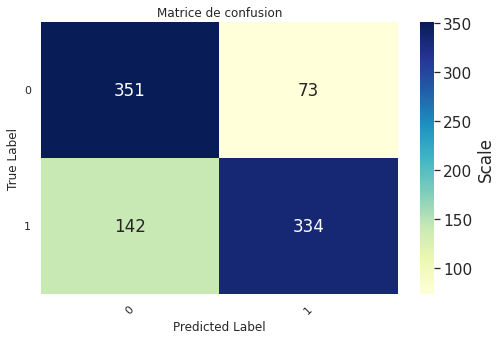

In [69]:
#from sklearn import metrics


y_pred = pipe.predict(X_test)

MyshowAllScores(y_test,y_pred)

L'objectif à présent est de pouvoir tester plusieurs pré-traitement et vectorisation afin de déterminer ceux qui amènent à la meilleure classification. Pour cela il suffit de créer autant de pipeline que l'on souhaite tester.

In [70]:
# pipeline de l'utilisation de CountVectorizer sur le texte presque sans traitement
CV_brut = Pipeline([("cleaner", TextNormalizer(removestopwords=True,lowercase=True,
                                               getstemmer=True,removedigit=True)), 
                    ("count_vectorizer", CountVectorizer(lowercase=False)),
                    ("SVM", SVC())])

# pipeline de l'utilisation de TfidfVectorizer sur le texte presque sans traitement
TFIDF_brut = Pipeline ([("cleaner", TextNormalizer(removestopwords=True,lowercase=True,
                                               getstemmer=True,removedigit=True)), 
                    ("count_vectorizer", TfidfVectorizer(lowercase=False)),
                    ("SVM", SVC())])

# Liste de tous les modèles à tester
all_models = [
    ("CV_brut", CV_brut),
    ("TFIDF_brut", TFIDF_brut)
]

L'évaluation se fait en utilisant cross_val_score qui effectue une cross validation et évalue le modèle.

In [71]:
from sklearn.model_selection import cross_val_score


# Evaluation des différents pipelines
unsorted_scores = [(name, cross_val_score(model, X, y, cv=5).mean()) for name, model in all_models]
scores = sorted(unsorted_scores, key=lambda x: -x[1])


print (tabulate(scores, floatfmt=".3f", headers=("Pipeline", 'Score')))


Pipeline      Score
----------  -------
TFIDF_brut    0.791
CV_brut       0.778


<font color=red>Exercice :</font> En vous inspirant du code précédent, proposer la combinaison pré-traitement, vectorisation qui permette d'obtenir le meilleur score de classification. 

<font color=blue> Solution :</font>
  

In [72]:
# le plus simple est de faire un test sur differents pipelines.  
# pipeline de l'utilisation de CountVectorizer sur le texte avec differents pre-traitements
CV_brut = Pipeline([('cleaner', TextNormalizer()), 
                    ('count_vectorizer', CountVectorizer(lowercase=False)),
                    ('svm', SVC())])
CV_lowcase = Pipeline([('cleaner', TextNormalizer(removestopwords=False,lowercase=True,
                                               getstemmer=False,removedigit=False)), 
                    ('count_vectorizer', CountVectorizer(lowercase=False)),
                    ('svm', SVC())])
CV_lowStop = Pipeline([('cleaner', TextNormalizer(removestopwords=True,lowercase=True,
                                               getstemmer=False,removedigit=False)), 
                    ('count_vectorizer', CountVectorizer(lowercase=False)),
                    ('svm', SVC())])

CV_lowStopstem = Pipeline([('cleaner', TextNormalizer(removestopwords=True,lowercase=True,
                                               getstemmer=True,removedigit=False)), 
                    ('count_vectorizer', CountVectorizer(lowercase=False)),
                    ('svm', SVC())])

# pipeline de l'utilisation de TfidfVectorizer avec differents pre-traitements
TFIDF_brut = Pipeline ([('cleaner', TextNormalizer()), 
                    ('tfidf_vectorizer', TfidfVectorizer(lowercase=False)),
                    ('svm', SVC())])

TFIDF_lowcase = Pipeline([('cleaner', TextNormalizer(removestopwords=False,lowercase=True,
                                               getstemmer=False,removedigit=False)), 
                    ('tfidf_vectorizer', TfidfVectorizer(lowercase=False)),
                    ('svm', SVC())])
TFIDF_lowStop = Pipeline([('cleaner', TextNormalizer(removestopwords=True,lowercase=True,
                                               getstemmer=False,removedigit=False)), 
                    ('tfidf_vectorizer', TfidfVectorizer(lowercase=False)),
                    ('svm', SVC())])

TFIDF_lowStopstem = Pipeline([('cleaner', TextNormalizer(removestopwords=True,lowercase=True,
                                               getstemmer=True,removedigit=False)), 
                    ('tfidf_vectorizer', TfidfVectorizer(lowercase=False)),
                    ("svm", SVC())])


# Liste de tous les modeles à tester
all_models = [
    ("CV_brut", CV_brut),
    ("CV_lowcase", CV_lowcase),
    ("CV_lowStop", CV_lowStop),
    ("CV_lowStopstem",CV_lowStopstem),
    ("TFIDF_lowcase", TFIDF_lowcase),
    ("TFIDF_lowStop", TFIDF_lowStop),
    ("TFIDF_lowStopstem",TFIDF_lowStopstem),
    ("TFIDF_brut", TFIDF_brut)
]


# Evaluation des differents pipelines
print ("Evaluation des différentes configurations : ")
unsorted_scores = [(name, cross_val_score(model, X, y, cv=5).mean()) for name, model in all_models]
scores = sorted(unsorted_scores, key=lambda x: -x[1])


print (tabulate(scores, floatfmt='.4f', headers=('Pipeline', 'Score')))

Evaluation des différentes configurations : 
Pipeline             Score
-----------------  -------
TFIDF_lowcase       0.8203
TFIDF_lowStop       0.8020
TFIDF_lowStopstem   0.7963
TFIDF_brut          0.7963
CV_lowStopstem      0.7800
CV_lowcase          0.7800
CV_lowStop          0.7760
CV_brut             0.7487


## **Evaluation de différents classifieurs**  



Dans cette section, nous évaluons différents classifieurs pour voir lequel est le plus performant. Comme nous appliquons pour chaque classifier les mêmes pré-traitements (appel de TextNormalizer sans paramètres) et l'obtention de la matrice pour tf-idf. Plutôt que de faire des pipelines et de relancer cette étape pour chaque classifier nous la réalisons en premier. Puis nous testons les différents classifiers via une cross validation.  

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# creation du tableau des différents classifieur 


models = []
models.append(('MultinomialNB',MultinomialNB()))
models.append(('LR', LogisticRegression(solver='lbfgs')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC()))



In [74]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


score = 'accuracy'
seed = 7        
allresults = []
results = []
names = []

X=df.sentence
y=df.sentiment

# Nous appliquons les pré-traitements sur X

text_normalizer=TextNormalizer()  
# appliquer fit.transform pour réaliser les pré-traitements sur X
X_cleaned=text_normalizer.fit_transform(X)

# pour l'enchainer avec un tf-idf et obtenir une matrice
tfidf=TfidfVectorizer()
features=tfidf.fit_transform(X_cleaned).toarray()

# attention ici il faut passer features dans cross_val_score plutôt que X
    
for name,model in models:
    # cross validation en 10 fois
    kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
    
    print ("Evaluation de ",name)
    start_time = time.time()
    # application de la classification
    cv_results = cross_val_score(model, features, y, cv=kfold, scoring=score)
    
    # pour afficher les paramètres du modèle en cours et la taille du vecteur intermédiaire
    # enlever le commentaire des deux lignes suivantes 
    #print ("paramètre du modèle ",model.get_params(),'\n')
    #print ("taille du vecteur : ",(model.named_steps['tfidf_vectorizer'].fit_transform(X)).shape,'\n')

    thetime=time.time() - start_time
    result=Result(name,cv_results.mean(),cv_results.std(),thetime)
    allresults.append(result)
    # pour affichage
    results.append(cv_results)
    names.append(name)
    print("%s : %0.3f (%0.3f) in %0.3f s" % (name, cv_results.mean(), cv_results.std(),thetime))         
    
allresults=sorted(allresults, key=lambda result: result.scoremean, reverse=True) 

# affichage des résultats
print ('\nLe meilleur resultat : ')
print ('Classifier : ',allresults[0].name, 
       ' %s : %0.3f' %(score,allresults[0].scoremean), 
       ' (%0.3f)'%allresults[0].stdresult,  
       ' en %0.3f '%allresults[0].timespent,' s\n')

print ('Tous les résultats : \n')
for result in allresults:
    print ('Classifier : ',result.name, 
       ' %s : %0.3f' %(score,result.scoremean), 
       ' (%0.3f)'%result.stdresult,  
       ' en %0.3f '%result.timespent,' s')

Evaluation de  MultinomialNB
MultinomialNB : 0.826 (0.013) in 1.095 s
Evaluation de  LR
LR : 0.824 (0.016) in 7.235 s
Evaluation de  KNN
KNN : 0.778 (0.013) in 4.020 s
Evaluation de  CART
CART : 0.712 (0.027) in 32.458 s
Evaluation de  RF
RF : 0.789 (0.018) in 74.957 s
Evaluation de  SVM
SVM : 0.837 (0.017) in 338.565 s

Le meilleur resultat : 
Classifier :  SVM  accuracy : 0.837  (0.017)  en 338.565   s

Tous les résultats : 

Classifier :  SVM  accuracy : 0.837  (0.017)  en 338.565   s
Classifier :  MultinomialNB  accuracy : 0.826  (0.013)  en 1.095   s
Classifier :  LR  accuracy : 0.824  (0.016)  en 7.235   s
Classifier :  RF  accuracy : 0.789  (0.018)  en 74.957   s
Classifier :  KNN  accuracy : 0.778  (0.013)  en 4.020   s
Classifier :  CART  accuracy : 0.712  (0.027)  en 32.458   s


[Text(0, 0, 'MultinomialNB'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'KNN'),
 Text(0, 0, 'CART'),
 Text(0, 0, 'RF'),
 Text(0, 0, 'SVM')]

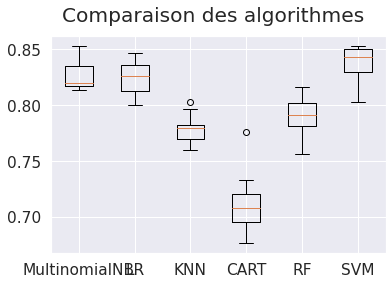

In [75]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig.suptitle('Comparaison des algorithmes')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

<font color=red>Exercice :</font> En vous inspirant du code précédent, évaluer les différents classifiers non plus par rapport à l'accuracy mais par rapport au rappel (*recall*) ou à la précision (*precision*). 

<font color=blue>Solution :</font> 

In [76]:
# il suffit de remplacer dans le code score ='recall' ou score='precision'.
print ("Pour le rappel : ")
score = 'recall'       
allresults = []
    
for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed,shuffle=True)
    print ("Evaluate ",name, 'pour ',score)
    start_time = time.time()
    # application de la classification
    cv_results = cross_val_score(model, features, y, cv=kfold, scoring=score)
    
    thetime=time.time() - start_time
    result=Result(name,cv_results.mean(),cv_results.std(),thetime)
    allresults.append(result)
    print("%s : %0.3f (%0.3f) in %0.3f s" % (name, cv_results.mean(), cv_results.std(),thetime))         
    
allresults=sorted(allresults, key=lambda result: result.scoremean, reverse=True) 

print ('Le meilleur resultat : ')
print ('Classifier : ',allresults[0].name, 
       ' %s : %0.3f' %(score,allresults[0].scoremean), 
       ' (%0.3f)'%allresults[0].stdresult,  
       ' en %0.3f '%allresults[0].timespent,' s')

print ()
print ('Tous les résultats : ')
for result in allresults:
    print ('Classifier : ',result.name, 
       ' %s : %0.3f' %(score,result.scoremean), 
       ' (%0.3f)'%result.stdresult,  
       ' en %0.3f '%result.timespent,' s')
    
    
print ()    
print ("Pour la precision : ")
score = 'precision'       
allresults = []
    
for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed,shuffle=True)
    print ("Evaluate ",name, 'pour ',score)
    start_time = time.time()
    # application de la classification
    cv_results = cross_val_score(model, features, y, cv=kfold, scoring=score)
    
    thetime=time.time() - start_time
    result=Result(name,cv_results.mean(),cv_results.std(),thetime)
    allresults.append(result)
    print("%s : %0.3f (%0.3f) in %0.3f s" % (name, cv_results.mean(), cv_results.std(),thetime))         
    
allresults=sorted(allresults, key=lambda result: result.scoremean, reverse=True) 

print ('Le meilleur resultat : ')
print ('Classifier : ',allresults[0].name, 
       ' %s : %0.3f' %(score,allresults[0].scoremean), 
       ' (%0.3f)'%allresults[0].stdresult,  
       ' en %0.3f '%allresults[0].timespent,' s')

print ('Tous les résultats : ')
for result in allresults:
    print ('Classifier : ',result.name, 
       ' %s : %0.3f' %(score,result.scoremean), 
       ' (%0.3f)'%result.stdresult,  
       ' en %0.3f '%result.timespent,' s') 

Pour le rappel : 
Evaluate  MultinomialNB pour  recall
MultinomialNB : 0.810 (0.021) in 1.027 s
Evaluate  LR pour  recall
LR : 0.808 (0.020) in 7.453 s
Evaluate  KNN pour  recall
KNN : 0.819 (0.015) in 3.959 s
Evaluate  CART pour  recall
CART : 0.716 (0.032) in 33.965 s
Evaluate  RF pour  recall
RF : 0.757 (0.024) in 76.614 s
Evaluate  SVM pour  recall
SVM : 0.807 (0.020) in 340.860 s
Le meilleur resultat : 
Classifier :  KNN  recall : 0.819  (0.015)  en 3.959   s

Tous les résultats : 
Classifier :  KNN  recall : 0.819  (0.015)  en 3.959   s
Classifier :  MultinomialNB  recall : 0.810  (0.021)  en 1.027   s
Classifier :  LR  recall : 0.808  (0.020)  en 7.453   s
Classifier :  SVM  recall : 0.807  (0.020)  en 340.860   s
Classifier :  RF  recall : 0.757  (0.024)  en 76.614   s
Classifier :  CART  recall : 0.716  (0.032)  en 33.965   s

Pour la precision : 
Evaluate  MultinomialNB pour  precision
MultinomialNB : 0.838 (0.026) in 0.931 s
Evaluate  LR pour  precision
LR : 0.836 (0.029) in

**Remarque :** dans les code précédents les différentes opérations efffectuées se font pour chaque classifieur : l'application des pré-traitements et la vectorisation avec TfidfVectorizer. Il aurait été bien sûr possible **et préférable** d'effectuer les prétraitements et vectorisation au préalable et d'appliquer uniquement les classifiers sur les données transformées.



## **Recherche des hyperparamètres**



Nous avons vu que SVM obtenait de bons résultats par rapport aux autres. Dans cette section nous étudions les hyperparamètres. Précédemment, nous avons vu après les avoir testé quels étaient également les meilleurs paramètres pour les pré-traitement et la vectorisation. Nous montrons aussi qu'il est possible de rechercher en même temps et de manière automatique quels sont les meilleurs paramètres.

SVM dispose de différents hyperparamètres qui peuvent être pris en compte dont les principaux sont :  
1. Le Noyaux (*kernel*) dont La fonction principale est de prendre un espace d'entrée de faible dimension et de le transformer en un espace de dimension supérieure. Il est surtout utile dans les problèmes de séparation non linéaire. Scikit learn propose les noyaux suivants : 'linear','poly','rbf','sigmoid'.
1. *C* (*regularization*) qui est le paramètre de pénalité, qui représente une mauvaise classification ou un terme d'erreur. Le terme de classification erronée ou d'erreur indique à l'optimisation SVM le niveau d'erreur supportable. Il permet de contrôler le compromis entre la frontière de décision un élément mal classé. En général plus C est grand mieux il classera les données mais cela entraîne aussi des fois du supapprentissage (*overfitting*). Inversement un C trop petit peut entraîner du sous-apprentissage (*underfitting*).
1. *Gamma* qui définit jusqu'où l'influence d'un seul exemple d'entraînement peut aller, avec des valeurs faibles signifiant «loin» et des valeurs élevées signifiant «proche». Lorsque Gamma est élevé, les points proches auront une forte influence; un gamma faible signifie par contre que des points éloignés doivent également être pris en compte pour obtenir la limite de décision.  

Vous pourrez trouver plus d'informations sur les hyperparamètres de SVM sous scikit learn ici : https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html  

Nous pouvons donc créer, à présent, un pipeline et spécifier les hyperparamètres à tester via GridSearchCV. Dans un premier temps, nous considérons un pipeline composé uniquent de la vectorisation et du classifier.  

**Remarque :** GridSearchCV effectue par défaut une cross validation (*cv*) avec une valeur par défaut de 5. Par contre étant donné qu'il fonctionne sur l'ensemble des données, il n'est pas possible par la suite de pouvoir obtenir d'autres mesures que celle qui est réalisée (notamment la matrice de confusion). Pour cela il est conseillé de couper le jeu de données en apprentissage (sur lequel sera appliqué le GridSearchCV) et un jeu de test avec 90/10.

In [77]:
# Création du jeu d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

Application de gridsearch ...
pipeline : ['tfidf', 'svm']
parameters :
{'svm__C': [0.001, 0.01, 0.1, 1, 10], 'svm__gamma': [0.001, 0.01, 0.1, 1], 'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid']}
Fitting 5 folds for each of 80 candidates, totalling 400 fits
réalisé en  222.490 s
Meilleur résultat : 0.828
Accuracy : 0.873
Classification Report
              precision    recall  f1-score   support

           0    0.87075   0.87075   0.87075       147
           1    0.87582   0.87582   0.87582       153

    accuracy                        0.87333       300
   macro avg    0.87328   0.87328   0.87328       300
weighted avg    0.87333   0.87333   0.87333       300



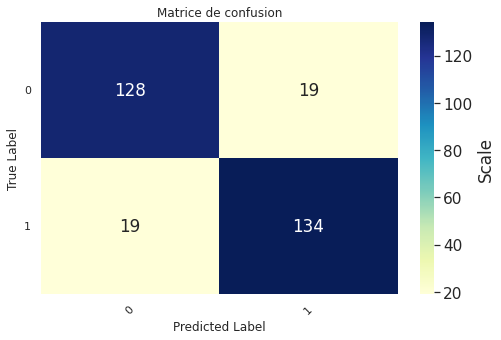

Ensemble des meilleurs paramètres :
	svm__C: 10
	svm__gamma: 1
	svm__kernel: 'rbf'

Les premiers résultats : 
     svm__C  svm__gamma svm__kernel  accuracy
77    10.0         1.0         rbf  0.827778
73    10.0         0.1         rbf  0.825556
61     1.0         1.0         rbf  0.822593
75    10.0         0.1     sigmoid  0.819630
56     1.0         0.1      linear  0.819259


In [78]:
from sklearn.model_selection import GridSearchCV


pipeline=Pipeline([("tfidf", TfidfVectorizer()),
                   ('svm', SVC())])

# creation des différents paramètres à tester pour SVM
# Attention dans le pipeline le nom pour le classifier SVM est : svm même si l'algorithme s'appelle SVC
# pour le référencer il faut utiliser le nom utilisé, i.e. svm, puis deux caractères soulignés
# et enfin le nom du paramètre
parameters = { 
     'svm__C': [0.001, 0.01, 0.1, 1, 10], 
    'svm__gamma' : [0.001, 0.01, 0.1, 1], 
    'svm__kernel': ['linear','rbf','poly','sigmoid']}
    

score='accuracy'

# Application de gridsearchcv, n_jobs=-1 permet de pouvoir utiliser plusieurs CPU s'ils sont disponibles
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1,scoring=score)

print("Application de gridsearch ...")
print("pipeline :", [name for name, _ in pipeline.steps])
print("parameters :")
print(parameters)
start_time = time.time()
grid_search.fit(X_train, y_train)
print("réalisé en  %0.3f s" % (time.time() - start_time))
print("Meilleur résultat : %0.3f" % grid_search.best_score_)

# autres mesures et matrice de confusion
y_pred = grid_search.predict(X_test)
MyshowAllScores(y_test,y_pred)


print("Ensemble des meilleurs paramètres :")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
# Affichage des premiers résultats du gridsearch
df_results=pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),
           pd.DataFrame(grid_search.cv_results_["mean_test_score"], 
                        columns=[score])],axis=1).sort_values(score,ascending=False)
print ("\nLes premiers résultats : \n",df_results.head()) 


**Remarque :** dans GridSearchCV, le paramètre utilisé *n_jobs=-1* permet de pouvoir réaliser des traitements en parallèle en utilisant tous les CPU de la machine. 

Et maintenant pourquoi ne pas rechercher également les meilleurs paramètres aussi bien pour le pré-traitement des données que pour la vectorisation et le classifier.  

**Attention :** cette recherche peut bien entendu être très longue aussi dans le code suivant nous ne traitons que quelques paramètres et simplifions les hyperparamètres de SVM. 

Nous considérons à présent principalement les paramètres associés à TfidfVectorizer.

Application de gridsearch ...
pipeline : ['cleaner', 'tfidf', 'svm']
parameters :
{'tfidf__stop_words': ['english', None], 'tfidf__lowercase': ['True', 'False'], 'svm__C': [1, 10], 'svm__gamma': [1], 'svm__kernel': ['rbf']}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
réalisé en  36.451 s
Meilleur résultat : 0.829
Accuracy : 0.877
Classification Report
              precision    recall  f1-score   support

           0    0.87671   0.87075   0.87372       147
           1    0.87662   0.88235   0.87948       153

    accuracy                        0.87667       300
   macro avg    0.87667   0.87655   0.87660       300
weighted avg    0.87667   0.87667   0.87666       300



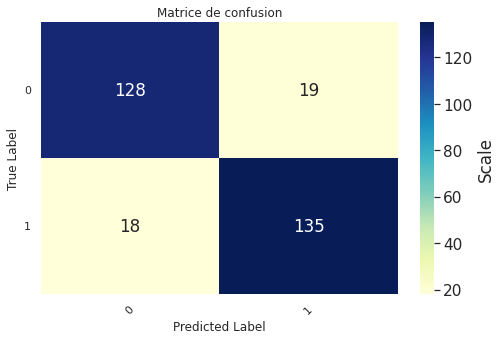

Ensemble des meilleurs paramètres :
	svm__C: 10
	svm__gamma: 1
	svm__kernel: 'rbf'
	tfidf__lowercase: 'True'
	tfidf__stop_words: None

Les premiers résultats : 
    svm__C  svm__gamma svm__kernel tfidf__lowercase tfidf__stop_words  accuracy
5      10           1         rbf             True              None  0.828889
7      10           1         rbf            False              None  0.828889
1       1           1         rbf             True              None  0.822963
3       1           1         rbf            False              None  0.822963
0       1           1         rbf             True           english  0.807407


In [79]:
pipeline=Pipeline([("cleaner", TextNormalizer()),
                   ("tfidf", TfidfVectorizer()),
                   ('svm', SVC())])


parameters = {
    'tfidf__stop_words':['english',None],
    'tfidf__lowercase': ['True','False'], 
     'svm__C': [1, 10], 
    'svm__gamma' : [1], 
    'svm__kernel': ['rbf']}
    
score='accuracy'
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1,  verbose=1, scoring=score)

print("Application de gridsearch ...")
print("pipeline :", [name for name, _ in pipeline.steps])
print("parameters :")
print(parameters)
start_time = time.time()
grid_search.fit(X_train, y_train)
print("réalisé en  %0.3f s" % (time.time() - start_time))
print("Meilleur résultat : %0.3f" % grid_search.best_score_)

# autres mesures et matrice de confusion
y_pred = grid_search.predict(X_test)
MyshowAllScores(y_test,y_pred)

print("Ensemble des meilleurs paramètres :")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
# Affichage des premiers résultats du gridsearch
df_results=pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),
           pd.DataFrame(grid_search.cv_results_["mean_test_score"], 
                        columns=[score])],axis=1).sort_values(score,ascending=False)
print ("\nLes premiers résultats : \n",df_results.head())  

Enfin, nous examinons l'impact de quelques paramètres notamment la racinisation associées au prétraitement.

Application de gridsearch ...
pipeline : ['cleaner', 'tfidf', 'svm']
parameters :
{'cleaner__getstemmer': ['True', 'False'], 'cleaner__removedigit': ['True', 'False'], 'cleaner__removestopwords': ['True', 'False'], 'tfidf__lowercase': ['True', 'False'], 'svm__C': [1, 10], 'svm__gamma': [1], 'svm__kernel': ['rbf']}
Fitting 5 folds for each of 32 candidates, totalling 160 fits
réalisé en  203.554 s
Meilleur résultat : 0.809
Accuracy : 0.877
Classification Report
              precision    recall  f1-score   support

           0    0.84810   0.91156   0.87869       147
           1    0.90845   0.84314   0.87458       153

    accuracy                        0.87667       300
   macro avg    0.87828   0.87735   0.87663       300
weighted avg    0.87888   0.87667   0.87659       300



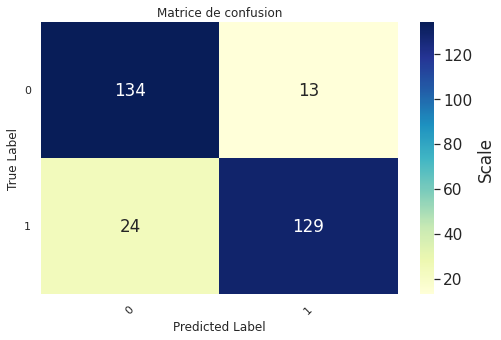

Ensemble des meilleurs paramètres :
	cleaner__getstemmer: 'True'
	cleaner__removedigit: 'True'
	cleaner__removestopwords: 'True'
	svm__C: 1
	svm__gamma: 1
	svm__kernel: 'rbf'
	tfidf__lowercase: 'True'

Les premiers résultats : 
    cleaner__getstemmer cleaner__removedigit  ... tfidf__lowercase  accuracy
0                 True                 True  ...             True  0.808519
12                True                False  ...             True  0.808519
29               False                False  ...            False  0.808519
28               False                False  ...             True  0.808519
25               False                False  ...            False  0.808519

[5 rows x 8 columns]


In [80]:
pipeline=Pipeline([("cleaner", TextNormalizer()),
                   ("tfidf", TfidfVectorizer()),
                   ('svm', SVC())])


parameters = {
    'cleaner__getstemmer': ['True','False'],
    'cleaner__removedigit':['True','False'],
    'cleaner__removestopwords':['True','False'],
    'tfidf__lowercase': ['True','False'], 
    'svm__C': [1, 10], 
    'svm__gamma' : [1], 
    'svm__kernel': ['rbf']}
    
score='accuracy'
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1,  verbose=1,scoring=score)

print("Application de gridsearch ...")
print("pipeline :", [name for name, _ in pipeline.steps])
print("parameters :")
print(parameters)
start_time = time.time()
grid_search.fit(X_train, y_train)
print("réalisé en  %0.3f s" % (time.time() - start_time))
print("Meilleur résultat : %0.3f" % grid_search.best_score_)

# autres mesures et matrice de confusion
y_pred = grid_search.predict(X_test)
MyshowAllScores(y_test,y_pred)


print("Ensemble des meilleurs paramètres :")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
# Affichage des premiers résultats du gridsearch
df_results=pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),
           pd.DataFrame(grid_search.cv_results_["mean_test_score"], 
                        columns=[score])],axis=1).sort_values(score,ascending=False)
print ("\nLes premiers résultats : \n",df_results.head()) 

La prochaine cellule s'intéresse à la lemmatisation et à son impact sur la classification.

Application de gridsearch ...
pipeline : ['cleaner', 'tfidf', 'svm']
parameters :
{'cleaner__getlemmatisation': ['True', 'False'], 'cleaner__removedigit': ['True', 'False'], 'cleaner__removestopwords': ['True', 'False'], 'tfidf__lowercase': ['True', 'False'], 'svm__C': [1, 10], 'svm__gamma': [1], 'svm__kernel': ['rbf']}
Fitting 5 folds for each of 32 candidates, totalling 160 fits
réalisé en  147.716 s
Meilleur résultat : 0.807
Accuracy : 0.837
Classification Report
              precision    recall  f1-score   support

           0    0.83108   0.83673   0.83390       147
           1    0.84211   0.83660   0.83934       153

    accuracy                        0.83667       300
   macro avg    0.83659   0.83667   0.83662       300
weighted avg    0.83670   0.83667   0.83668       300



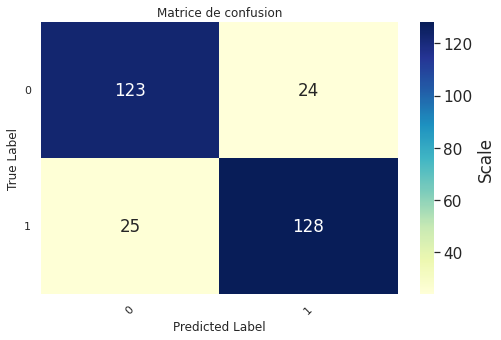

Ensemble des meilleurs paramètres :
	cleaner__getlemmatisation: 'True'
	cleaner__removedigit: 'True'
	cleaner__removestopwords: 'True'
	svm__C: 10
	svm__gamma: 1
	svm__kernel: 'rbf'
	tfidf__lowercase: 'True'

Les premiers résultats : 
    cleaner__getlemmatisation cleaner__removedigit  ... tfidf__lowercase  accuracy
31                     False                False  ...            False  0.807407
27                     False                False  ...            False  0.807407
19                     False                 True  ...            False  0.807407
18                     False                 True  ...             True  0.807407
23                     False                 True  ...            False  0.807407

[5 rows x 8 columns]


In [81]:
pipeline=Pipeline([("cleaner", TextNormalizer()),
                   ("tfidf", TfidfVectorizer()),
                   ('svm', SVC())])


parameters = {
    'cleaner__getlemmatisation': ['True','False'],
    'cleaner__removedigit':['True','False'],
    'cleaner__removestopwords':['True','False'],
    'tfidf__lowercase': ['True','False'], 
    'svm__C': [1, 10], 
    'svm__gamma' : [1], 
    'svm__kernel': ['rbf']}
    
score='accuracy'
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1,  verbose=1,scoring=score)

print("Application de gridsearch ...")
print("pipeline :", [name for name, _ in pipeline.steps])
print("parameters :")
print(parameters)
start_time = time.time()
grid_search.fit(X_train, y_train)
print("réalisé en  %0.3f s" % (time.time() - start_time))
print("Meilleur résultat : %0.3f" % grid_search.best_score_)

# autres mesures et matrice de confusion
y_pred = grid_search.predict(X_test)
MyshowAllScores(y_test,y_pred)


print("Ensemble des meilleurs paramètres :")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
# Affichage des premiers résultats du gridsearch
df_results=pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),
           pd.DataFrame(grid_search.cv_results_["mean_test_score"], 
                        columns=[score])],axis=1).sort_values(score,ascending=False)
print ("\nLes premiers résultats : \n",df_results.head()) 

<font color=red>Exercice :</font> Comparer attentivement les  dernières exécutions. Que pouvez vous en déduire sur la meilleure configuration ? Quel est l'impact des paramètres de pré-traitement et de vectorisation ? Quel pouvez vous en déduire de manière générale ? 

<font color=blue>Solution :</font> 


In [82]:
# Il s'avère que parfois les pré-traitements n'améliore pas forcément  (par exemple la lemmatisation)
# et que l'accuracy diminue.  Pourtant si l'on regarde la première expérimentation il s'avère qu'elle revient 
# à traiter le texte brut sans aucun pré-traitemet et que les quelques légers pré-traitement de base 
# suppression de caractères spéciaux, etc permettent d'améliorer très légérement les résultats (0.824 vs 0.825).  
# La question par contre, de manière générale, est comment améliorer ces résultats. En fait si l'on 
# regarde plus en détail les données on peut constater que le jeu de données n'est pas très volumineux et 
# qu'il n'y a pas forcément possibilité de mieux discriminer les avis positifs ou négatifs. 
# Pour améliorer la classification il existe cependant de nombreuses pistes d'autres pré-traitements 
# (e.g. ne retenir que des verbes, adjectifs souvent porteurs d'opinions et adverbe, 
# regarder plus spécifiquement les données positives et négatives (e.g. mieux analyser les données), 
# utiliser d'autres classifier ou d'autres types de classifiers (e.g. LR, CNN, etc.), utiliser 
# d'autres approches de représentation des données (e.g. des embeddings que nous verrons plus tard), 
# enrichir les données, ..... bref de très nombreuses pistes de recherche.

<font color=red>Exercice :</font> Dans le code ci-dessous, sélectionner un classifier et ses paramètres associés afin de tester s'il obtient de meilleurs résultats que SVM. Pour cela, il suffit de décommenter les lignes associèes au classifier que vous désirez et exécuter la cellule.  
Le code actuel permet de lancer la classifier LogisticRegression. Ne pas oublier de commenter les lignes associées pour tester d'autres classifiers.

Application de gridsearch ...
pipeline : ['cleaner', 'tfidf', 'lr']
parameters :
{'lr__solver': ['newton-cg', 'lbfgs', 'liblinear'], 'lr__penalty': ['l2'], 'lr__C': [100, 10, 1.0, 0.1, 0.01]}
Fitting 5 folds for each of 15 candidates, totalling 75 fits
réalisé en  34.322 s
Meilleur résultat : 0.818
Accuracy : 0.997
Classification Report
              precision    recall  f1-score   support

           0    0.99324   1.00000   0.99661       147
           1    1.00000   0.99346   0.99672       153

    accuracy                        0.99667       300
   macro avg    0.99662   0.99673   0.99667       300
weighted avg    0.99669   0.99667   0.99667       300



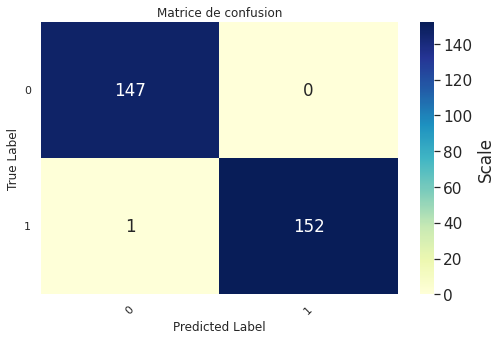

Ensemble des meilleurs paramètres :
	lr__C: 10
	lr__penalty: 'l2'
	lr__solver: 'newton-cg'

Les premiers résultats : 
    lr__C lr__penalty lr__solver  accuracy
3   10.0          l2  newton-cg  0.818333
4   10.0          l2      lbfgs  0.818333
5   10.0          l2  liblinear  0.818333
0  100.0          l2  newton-cg  0.812667
1  100.0          l2      lbfgs  0.812667


In [83]:
# Pour information le nombre de paramètres à tester a été défini de manière 
# à ce que les tests ne soient pas trop longs

pipeline=Pipeline([("cleaner", TextNormalizer()),
                   ("tfidf", TfidfVectorizer()),
    
                   # pour LogisticRegression enlever le commentaire de la ligne suivante
                   ("lr", LogisticRegression()),
    
                   # pour MultinomialNB enlever le commentaire de la ligne suivante 
                   #("mnb", MultinomialNB()),
    
                   # pour RandomForestClassifier enlever le commentaire de la ligne suivante
                   #('rfc', RandomForestClassifier())
                  ]
                 )


parameters = {
    # Pour logisticRegression enlever les commentaires des 3 lignes suivantes :
    'lr__solver' : ['newton-cg', 'lbfgs', 'liblinear'],
    'lr__penalty' : ['l2'],
    'lr__C' : [100, 10, 1.0, 0.1, 0.01],
    
    # Pour MulinomialNaiveBayes enlever les commentaires des 2 lignes suivantes :
    #'mnb__alpha': np.linspace(0.5, 1.5, 6),
    #'mnb__fit_prior': [True, False],  
    
    # pour RandomForestClassifier enlever les commentaires des 4 lignes suivantes :
    #'rfc__n_estimators': [500, 1200],
    #'rfc__max_depth': [25, 30],
    #'rfc__min_samples_split': [5, 10, 15],
    #'rfc__min_samples_leaf' : [1, 2], 
    }
     
    
score='accuracy'
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1,  verbose=1,scoring=score)

print("Application de gridsearch ...")
print("pipeline :", [name for name, _ in pipeline.steps])
print("parameters :")
print(parameters)
start_time = time.time()
grid_search.fit(X, y)
print("réalisé en  %0.3f s" % (time.time() - start_time))
print("Meilleur résultat : %0.3f" % grid_search.best_score_)

# matrice de confusion
y_pred = grid_search.predict(X_test)
MyshowAllScores(y_test,y_pred)

print("Ensemble des meilleurs paramètres :")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
# Affichage des premiers résultats du gridsearch
df_results=pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),
           pd.DataFrame(grid_search.cv_results_["mean_test_score"], 
                        columns=[score])],axis=1).sort_values(score,ascending=False)
print ("\nLes premiers résultats : \n",df_results.head()) 

## **Sauvegarde du modèle**

Dans cette section nous sauvegardons le modèle pour pouvoir l'utiliser ultérieurement. Pour cela, nous utilisons simplement un pipeline en utilisant les paramètres et hyperparamètres qui ont été appris précédemment. Nous l'appliquons cette fois-ci à l'ensemble du jeu de données et non plus à un sous ensemble (X_train).  

In [84]:
X=df.sentence
y=df.sentiment

pipeline=Pipeline([("cleaner", TextNormalizer()),
                   ("tfidf", TfidfVectorizer(lowercase='True')),
                   ('svm', SVC(C=1, gamma=1,kernel='rbf'))])
pipeline.fit(X,y)
filename='SentimentModel.pkl'
print("Sauvegarde du modèle dans ", filename)
pickle.dump(pipeline, open(filename, "wb"))

Sauvegarde du modèle dans  SentimentModel.pkl


Maintenant qu'un modèle a été appris et sauvegardé .... il suffit de l'utiliser. Pour cela rendez vous sur le notebook **Utiliser un modele appris** ...